<a href="https://colab.research.google.com/github/decorouz/DeepLeaning-with-Tensorflow/blob/main/5_0_Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#5.0 Deep learning for computer vision

### 5.1 Introduction of Convolutional Neural Network (Convnets)



##### 5.1.1 Instantiating a small convnet

In [51]:
from keras import layers
from keras import models
import random

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))

Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)`.

In this case, we'll configure the convnet to process inputs of size `(28,28,1)` which is the format of the MNIST images.

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

The output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor.

The number of channels is controlled by the first argument passed to the `ConvD layers` (32 or 64).

##### 5.1.2 Adding a classifier on the top of the convnet

In [ ]:
# Adding a classifier on the top of the convnet
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

##### 5.1.3 Training the convnet on MNIST Images

In [ ]:
# Training the convnet on MNIST Images
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
import numpy as np

def to_one_hot(labels, dimension=10):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] += 1.
  return results

In [ ]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

# custom vectorizer
# train_labels = to_one_hot(train_labels)
# test_labels = to_one_hot(test_labels)

# built in method
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, 
          train_labels, 
          epochs=5, 
          batch_size=64)

Epoch 1/5
938/938 [==============================] - 51s 54ms/step - loss: 0.1766 - accuracy: 0.9438
Epoch 2/5
938/938 [==============================] - 44s 47ms/step - loss: 0.0459 - accuracy: 0.9860
Epoch 3/5
938/938 [==============================] - 42s 44ms/step - loss: 0.0323 - accuracy: 0.9899
Epoch 4/5
938/938 [==============================] - 42s 45ms/step - loss: 0.0238 - accuracy: 0.9929
Epoch 5/5
938/938 [==============================] - 41s 44ms/step - loss: 0.0194 - accuracy: 0.9939


In [ ]:
train_labels.shape

(60000, 10)

In [ ]:
# Let's evaluate the model on the test_data
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 4s 11ms/step - loss: 0.0273 - accuracy: 0.9911


In [ ]:
print(f"The test accuracy is {test_acc:.2f}")
print(f"The test loss on the test dataset is {test_loss:.2f}")

The test accuracy is 0.99
The test loss on the test dataset is 0.03


### 5.2 The Convolution Operation

The **difference between** a densely connected layer and a convolution layer is this; Dense layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns.

* The patterns they learn are translation invariant:
* They can learn spatial hierarchies of patterns

Convolutions operate over 3D tensors, called *feature maps* with two spatial axes (height and width) as well as depth (also called channels axis).

The convoluation operation extracts patches from its input feature map and applies the same transformation to all these patches, producing an output feature map.

The output feature map is still a 3D tensor; it has a width and a height. It depth can be abitrary, because the output depth is a paramter of the layer; it stands for filters.

In the MNIST example, the first convolution layer takes a feature map of size (28,28,1) and outputs a feature map of size (26,26,32): it computes 32 filters over its input. Each of these 32 output channels contain a 26*26 grid of values which is a *response map* of the filter over the input.

***Feature map***: every dimension in the depth axis is a feature, and the 2D tensors output [:,:,n] in the 2D spatial map of the response of this filter over the input.

Convolutions are defined by **two key parameters**:
* Size of the patches extracted from the inputs
* Depth of the output feature map

In Keras, 
```
Conv2D(output_depth, (window_height, window_width)
```

**Reason why the output width and height** may differ from input width and height.
* **Border effects** which can be countered by padding the input feature map:
* The use of *strides*: The distance between two successive windows is call strides. Using stride 2 means the width and height of the feature map are downsampled by a factor of 2. Instead to downsample feature maps, we tend to use *max-pooling*

### 5.3 The max-pooling operation

The role of max pooling is aggressively downsample feature maps. It consist of extracting windows from the input feature maps and outputting the max value of each channel.

In [ ]:
# Why downsample feature maps

model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3,3), activation="relu",input_shape=(28,28,1)))
model_no_max_pool.add(layers.Conv2D(64, (3,3), activation="relu"))
model_no_max_pool.add(layers.Conv2D(64, (3,3), activation="relu"))

In [ ]:
model_no_max_pool.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


The reason to use downsampling is to reduce the number of **feature-map** coefficients to process, as well as to induce spatial-filter hierarcheis by making successive convolution layers look at increasingly large windows.

**What is feature maps?**: The basic idea of neural network is that neurons learn features from inputs.In CNN, the feature map is the output of one filter applied to the previous layer.

### 5.4 Training a convnet from scratch on a small dataset

Having a to train an image classification model using very little data is a common situation, which you'll likely encounter in practice.

* Train naively with the little data available.
* Data augmentation
* Feature extraction with a pretrained network
* Fine-tuning a pretrained network

#### 5.4.1 Downloading the data
The dataset is made available by Kaggle in late 2013. Yoou can download the original dataset from [here](www.kaggle.com/c/dogs-vs-cats/data).

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing it, you’ll create a new
dataset containing three subsets: a training set with 1,000 samples of each class, a validation
set with 500 samples of each class, and a test set with 500 samples of each class.

In [ ]:
# Importing the required packages
import os, shutil
import zipfile

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2023-02-09 13:04:30--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.80.228.159, 2a02:26f0:9100:18b::317f, 2a02:26f0:9100:188::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.80.228.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   121MB/s    in 6.6s    

2023-02-09 13:04:37 (119 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
# unzip the file
local_zip = "/tmp/cats-and-dogs.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
source_path = "/tmp/PetImages"

source_path_dogs = os.path.join(source_path, "Dog")
source_path_cats = os.path.join(source_path, "Cat")

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

In [ ]:
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


##### 5.4.1.1 Create train, validation and test directory

In [ ]:


base_dir = "/tmp/cats_and_dogs"

# Empty directory to prevent FileExistError when the function is run several times
if os.path.exists(base_dir):
  shutil.rmtree(base_dir)


def create_train_validation_test_dirs(root_dir):

  '''
  Create directory for train, validation and test images

  Args:
    root_dir(string): the base directory path to create subdirectories

  Returns
    None
  '''
  train_dir = os.path.join(root_dir, "train")             
  os.makedirs(train_dir)                                   # Dir for training
  validation_dir = os.path.join(root_dir, "validation")
  os.makedirs(validation_dir)                              # Dir for validation
  test_dir = os.path.join(root_dir, "test")
  os.makedirs(test_dir)                                    # Dir for testing

  # Directory with training cat images 
  train_cats_dir = os.path.join(train_dir, "cats")
  os.makedirs(train_cats_dir)

  # Directory with training dog images 
  train_dogs_dir = os.path.join(train_dir, "dogs")
  os.makedirs(train_dogs_dir)

  # Directory with validation cat images
  validation_cats_dir = os.path.join(validation_dir, "cats")
  os.makedirs(validation_cats_dir)

  # Directory with validation dog images 
  validation_dogs_dir = os.path.join(validation_dir, "dogs")
  os.makedirs(validation_dogs_dir)

  # Directory with testing cat images 
  test_cats_dir = os.path.join(test_dir, "cats")
  os.makedirs(test_cats_dir)

  # Directory with testing dog images
  test_dogs_dir = os.path.join(test_dir, "dogs")
  os.makedirs(test_dogs_dir)


In [ ]:
# Test create_train_validation_test_dirs

try:
  create_train_validation_test_dirs(root_dir=base_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")



In [ ]:

for root_dirs, dirs, files in os.walk(base_dir):
  for subdir in dirs:
    print(os.path.join(root_dirs, subdir))

/tmp/cats_and_dogs/train
/tmp/cats_and_dogs/validation
/tmp/cats_and_dogs/test
/tmp/cats_and_dogs/train/dogs
/tmp/cats_and_dogs/train/cats
/tmp/cats_and_dogs/validation/dogs
/tmp/cats_and_dogs/validation/cats
/tmp/cats_and_dogs/test/dogs
/tmp/cats_and_dogs/test/cats


##### 5.4.1.2 Copying images to training, validation and test directories

In [ ]:
# Copying images to training, validation and test directories into split
import numpy as np

def split_data(SOURCE_DATASET_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, SPLIT_SIZE):
  # check for valid files in the directory
  valid_files = []
  for fname in os.listdir(SOURCE_DATASET_DIR):
    file_path = SOURCE_DATASET_DIR + fname
    if os.path.getsize(file_path) >0:
      valid_files.append(fname)
    else:
      print(f"{fname} is zero length, therefore ignoring ")

  num_valid_files = len(valid_files)

  shuffled_file_dir = random.sample(valid_files, num_valid_files)     # shuffle the dataset
  train_split_point = int(num_valid_files * SPLIT_SIZE + 1)           # select only 1000 images for training


  train_set = valid_files[:train_split_point]                         # copies the first 1000 training images
  validation_set = valid_files[train_split_point: 1500]               # copies the next 500 images
  test_set = valid_files[1500 : 2000]                                 # copies the next 500 images

  for fname in train_set:
    source = os.path.join(SOURCE_DATASET_DIR, fname)
    train_destination = os.path.join(TRAINING_DIR, fname)
    shutil.copyfile(source, train_destination)

  for fname in validation_set:
    source = os.path.join(SOURCE_DATASET_DIR, fname)
    val_distination = os.path.join(VALIDATION_DIR, fname)
    shutil.copyfile(source, val_distination)

  for fname in test_set:
    source = os.path.join(SOURCE_DATASET_DIR, fname)
    test_distination = os.path.join(TEST_DIR, fname)
    shutil.copyfile(source, test_distination)


##### 5.4.1.3 Test Split function

In [ ]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats_and_dogs/train/"
VALIDATION_DIR = "/tmp/cats_and_dogs/validation/"
TESTING_DIR = "/tmp/cats_and_dogs/test/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = 0.08                                   # Coping only 1000 copies of dog and cat images each.

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, therefore ignoring 
11702.jpg is zero length, therefore ignoring 


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 1000 images of cats for training
There are 1000 images of dogs for training
There are 500 images of cats for validation
There are 500 images of dogs for validation
There are 500 images of cats for testing
There are 500 images of dogs for testing


#### 5.4.2 Building the network

This is a classification problem, hence we will end up with single unit.

The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (from 148 * 148 to 7 * 7).

In [ ]:

from keras import models
from keras import layers

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(150,150,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

Let's look at how the dimension of the feature maps change with every successive layer

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

#### 5.4.3 Data Processing

Data should be formatted into appropiate preprocess floating point tensors before being fed into the network.

* Read the image files
* Decode the jpeg content to RGB grids pixesl
* Convert these into floating point tensors
* Rescale the pixels to [0,1] interval.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def generate_train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  
  IMAGE_SIZE = (150, 150)
  BATCH_SIZE = 20

  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                      target_size=IMAGE_SIZE,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="binary")
  
  val_generator = test_datagen.flow_from_directory(VALIDATION_DIR,
                                                   target_size=IMAGE_SIZE,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode="binary")
  
  return train_generator, val_generator


In [ ]:
# Test the generators.
train_generator, val_generator = generate_train_val_generators(TRAINING_DIR=TRAINING_DIR, 
                                                               VALIDATION_DIR=VALIDATION_DIR)b

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Lets look at the output of one these generators. Note that the generator yileds these batchess indefinitely. For this reason, you need to break the iteration loop at some point

In [ ]:
for image_batch, labels_batch in train_generator:
  print("data batch shape:", image_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


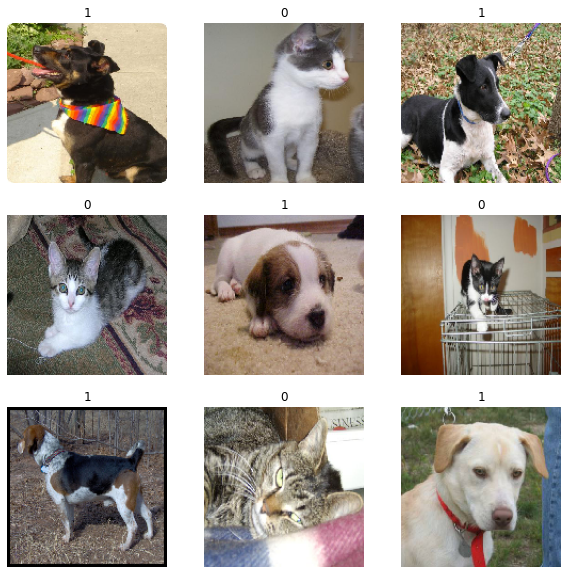

In [ ]:
# Lets visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_generator:
  
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(int(labels[i]))
    plt.axis("off")
  break

#### 5.4.4 Fitting the model using a batch generator


`steps_per_epoch`: Keras model needs to now how many samples to draw from the generator before declaring an epoch over. After having drawn `steps_per_epoch` batches from the generator-- the fitting process will go the next epoch. In this case, btaches are 20samples, so it ill take 100 batches until you see your target of 2000 samples


In [ ]:

history = model.fit_generator(
    train_generator,
    steps_per_epoch= 100,
    epochs=20,
    validation_data=val_generator,
    validation_steps=50
)

Epoch 1/20


<ipython-input-30-c88b20d615f8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 94s 935ms/step - loss: 0.6939 - accuracy: 0.5295 - val_loss: 0.6907 - val_accuracy: 0.5010
Epoch 2/20
100/100 [==============================] - 93s 932ms/step - loss: 0.6665 - accuracy: 0.6075 - val_loss: 0.6653 - val_accuracy: 0.5430
Epoch 3/20
100/100 [==============================] - 96s 949ms/step - loss: 0.6302 - accuracy: 0.6395 - val_loss: 0.6619 - val_accuracy: 0.5510
Epoch 4/20
100/100 [==============================] - 95s 953ms/step - loss: 0.5901 - accuracy: 0.6950 - val_loss: 0.5789 - val_accuracy: 0.6890
Epoch 5/20
100/100 [==============================] - 95s 951ms/step - loss: 0.5602 - accuracy: 0.7100 - val_loss: 0.5685 - val_accuracy: 0.6980
Epoch 6/20
100/100 [==============================] - 94s 945ms/step - loss: 0.5369 - accuracy: 0.7305 - val_loss: 0.5439 - val_accuracy: 0.7170
Epoch 7/20
100/100 [==============================] - 101s 1s/step - loss: 0.5001 - accuracy: 0.7590 - val_loss: 0.5503 - val_accuracy: 0.721

In [ ]:
# Saving the model
model.save("cats_and_dogs_small_1.h5")

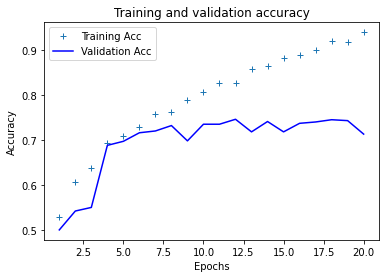

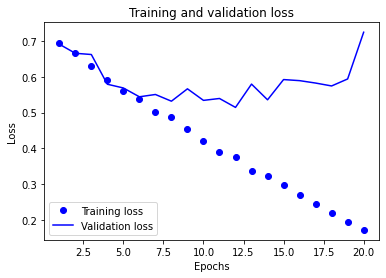

In [ ]:
# Displaying curves of loss and accuracy during training
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------

plt.plot(epochs, acc, "+", label="Training Acc")
plt.plot(epochs, val_acc, "b", label="Validation Acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

These plots are characteristics of overfitting. The training accuracy increases linearly over time, whereas the validation accuracy stalls at 70-75%.


####5.4.5 Using Data Augmentation

Overfitting is caused by having too few to learn from. Data augmentation takes the approach of generating more training data from existing training samples by *augmenting* samples via a number of random transformations.

In [ ]:
##### 5.4.5.1 Setting up data augmentation configuration via IMageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range =40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
## Displaying some randomly augmented training images

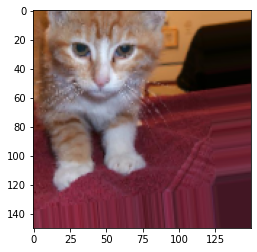

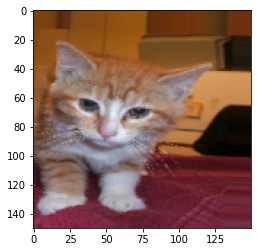

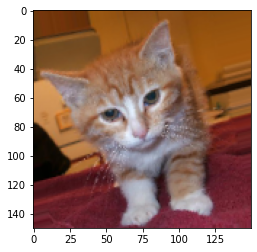

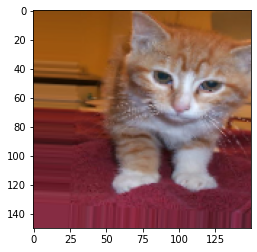

In [ ]:
import keras.utils as image

fnames = [os.path.join(TRAINING_CATS_DIR, fname) for fname in os.listdir(TRAINING_CATS_DIR)]

img_path = fnames[3]

img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)

i=0

for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%4 == 0:
    break
plt.show()

Note: When you train a new network using data -augmentation configuration,  the netowkr will never see the same input twice

In [ ]:
# Defining a new convnet that includes dropout

In [52]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))


model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])



In [53]:
# Training the Convnet using Augmentation generators
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 128)       36992     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 128)     

In [54]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode="binary")
validation_generator = test_datagen.flow_from_directory(VALIDATION_DIR,
                                                        target_size=(150,150),
                                                        batch_size=32,
                                                        class_mode="binary")



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [56]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/32,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/32
)

<ipython-input-56-949be6c39dbc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
62/62 [==============================] - 150s 2s/step - loss: 0.6885 - accuracy: 0.5485 - val_loss: 0.6695 - val_accuracy: 0.5170
Epoch 2/100
62/62 [==============================] - 151s 2s/step - loss: 0.6746 - accuracy: 0.5855 - val_loss: 0.6307 - val_accuracy: 0.6310
Epoch 3/100
62/62 [==============================] - 151s 2s/step - loss: 0.6597 - accuracy: 0.5955 - val_loss: 0.6061 - val_accuracy: 0.6770
Epoch 4/100
62/62 [==============================] - 149s 2s/step - loss: 0.6464 - accuracy: 0.6325 - val_loss: 0.5954 - val_accuracy: 0.6720
Epoch 5/100
62/62 [==============================] - 149s 2s/step - loss: 0.6312 - accuracy: 0.6505 - val_loss: 0.5704 - val_accuracy: 0.7200
Epoch 6/100
62/62 [==============================] - 148s 2s/step - loss: 0.6169 - accuracy: 0.6510 - val_loss: 0.5826 - val_accuracy: 0.6730
Epoch 7/100
62/62 [==============================] - 149s 2s/step - loss: 0.6130 - accuracy: 0.6615 - val_loss: 0.5627 - val_accuracy: 0.7040
Epoch 

In [57]:
# Saving the model

In [58]:
model.save("cats_and_dogs_small_2.h5")

In [ ]:
history.history

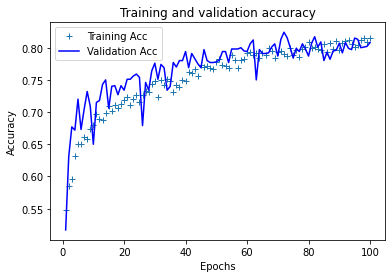

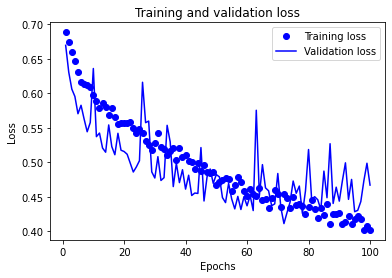

In [60]:
# Displaying curves of loss and accuracy during training
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------

plt.plot(epochs, acc, "+", label="Training Acc")
plt.plot(epochs, val_acc, "b", label="Validation Acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

By using regularization techniques, and by turning the networks parameters, I was able to get an even ebtter accuracy of close to 87%.